In [1]:
import pandas as pd
import numpy as np
from lib.plot_jzar import *
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [72]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows', 10)

### We have 3 types of data:

- Independent features (clustered)
- `How good the route is (the higher the better)` => <b>In this notebook we will work on this one
- Grade, Location, sex, heigh (defined by user)


# Routes rating

Objective
- We want to convert all the "rating" columns into a single one

In [73]:
routes = pd.read_csv('../data/routes_clustered.csv',low_memory=False, index_col=0)
print(routes.shape)
routes.tail(3)

(55858, 15)


,name_id,country,crag,sector,name,ascents_count,repeat_sum,recommend_sum,tall_recommend_sum,grade_mean,sentiment_mean,rating_mean,yellow_id_mean,first_ascent_mean,cluster
55855,55855,zaf,van stadens,cleopatra wall,sunset sonata,2,0.0,0.0,1,54.5,0.8636,3.0,255.0,0.5,2
55856,55856,zaf,van stadens,cleopatra wall,tekel,2,0.0,1.0,0,44.0,NaN,2.0,0.0,0.0,0
55857,55857,zaf,waterval boven,baboon buttress,pretenders,2,0.0,1.0,0,49.0,0.8020,NaN,255.0,0.0,1


## Prepare the dataframe

We will use the following values
- rating_mean -> the mean value of the route rating
- repeat_rate -> the sum of times that the route have been repeated by the same person divided by ascensions
- recommend_rate -> times that the route has been recommended divided by ascensions
- sentiment_rate -> sentiment count divided by comments count

In [74]:
routes_rate = routes.copy()
routes_rate['recommend_rate'] = routes_rate.recommend_sum / routes_rate.ascents_count

routes_rate = routes_rate[['rating_mean','recommend_rate','sentiment_mean']]
print(routes_rate.shape)
routes_rate.tail(3)

(55858, 3)


,rating_mean,recommend_rate,sentiment_mean
55855,3.0,0.0,0.8636
55856,2.0,0.5,NaN
55857,NaN,0.5,0.8020


Replace nan by mean

In [75]:
routes_rate.isna().sum()

rating_mean        5881
recommend_rate        0
sentiment_mean    10039
dtype: int64

In [76]:
routes_rate.rating_mean = routes_rate.rating_mean.fillna(np.mean(routes_rate.rating_mean))

In [77]:
routes_rate.rating_mean.hist()

<Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>

In [78]:
routes_rate.replace([np.inf, -np.inf], np.nan, inplace=True)
routes_rate.sentiment_mean = routes_rate.sentiment_mean.fillna(0)
routes_rate.sentiment_mean.hist()

<Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>

In [79]:
routes_rate.sentiment_mean.value_counts()

 0.000000    24601
 0.421500      294
-0.004215      225
-0.102700      186
 0.210750      184
             ...  
 0.148983        1
-0.035073        1
 0.319169        1
-1.000000        1
 0.863600        1
Name: sentiment_mean, Length: 23720, dtype: int64

In [80]:
routes_rate.recommend_rate.hist()

<Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>

 #### Scale them

In [81]:
X = routes_rate.copy()
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "../transformer/scaler_rating.pickle" # Path with filename
with open(filename, "wb") as file:
        pickle.dump(scaler,file)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
print(X_scaled_df.shape)
display(X_scaled_df.head(3))

(55858, 3)


,rating_mean,recommend_rate,sentiment_mean
0,0.500,0.000000,0.420345
1,0.500,0.166667,0.420345
2,0.375,0.200000,0.420345


## Group the 3 features into one

### Check the PCA

In [82]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.70292646, 0.17707946, 0.11999408])

We see that we have one component as high as 70 percent. Then we will take this one as the rating main component

#### Check the distribution

<IPython.core.display.Javascript object>


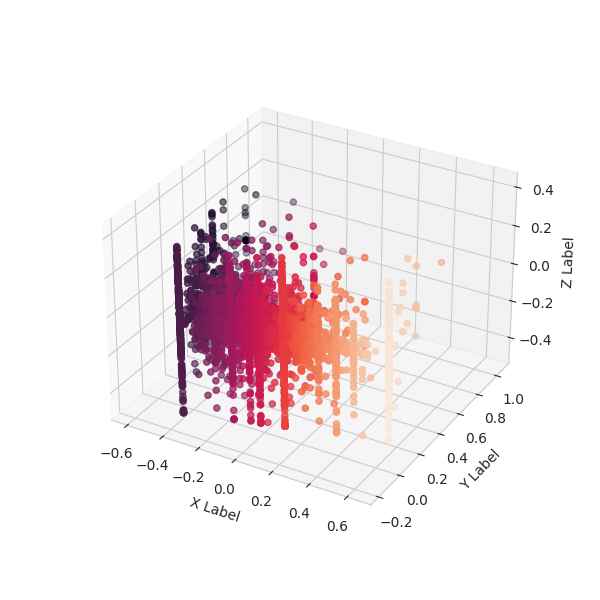

In [84]:
%matplotlib notebook
plot3D(x = principalDf[0],y = principalDf[1],z = principalDf[2],color = principalDf[0], fraction = 0.1)

In [85]:
routes['rating_tot'] = principalDf[1]

In [86]:
routes = routes.drop(columns = ['repeat_sum','rating_mean','ascents_count','sentiment_mean','recommend_sum','yellow_id_mean','first_ascent_mean'])
routes.head()

,name_id,country,crag,sector,name,tall_recommend_sum,grade_mean,cluster,rating_tot
0,0,and,montserrat,prohibitivo,diagonal de la x,-1,49.250000,0,-0.045211
1,1,and,montserrat,prohibitivo,mehir,-1,49.000000,0,0.116464
2,2,and,montserrat,prohibitivo,pas de la discordia,0,49.000000,0,0.178722
3,3,and,tartareu,bombo suis,tenedor libre,0,44.333333,0,0.158449
4,4,arg,bandurrias,rincon,tendinitis,1,48.500000,0,0.075797


In [87]:
routes.to_csv('../data/routes_rated.csv')

In [88]:
print("Positive rating: ", sum(routes.rating_tot > 0))
print("Negative rating: ", sum(routes.rating_tot < 0))

Positive rating:  20544
Negative rating:  35314
